In [1]:
import matplotlib; matplotlib.use('Agg')
import torch
import os
import time
from shutil import copy
import datetime
import imp
from tensorboardX import SummaryWriter
import numpy as np
import random
from torch import autograd
from torch.optim import Adam, RMSprop, SGD
from functools import partial

from spirl.components.data_loader import RandomVideoDataset
from spirl.utils.general_utils import RecursiveAverageMeter, map_dict
from spirl.components.checkpointer import CheckpointHandler, save_cmd, save_git, get_config_path
from spirl.utils.general_utils import dummy_context, AttrDict, get_clipped_optimizer, \
                                                        AverageMeter, ParamDict
from spirl.utils.pytorch_utils import LossSpikeHook, NanGradHook, NoneGradHook, \
                                                        DataParallelWrapper, RAdam
from spirl.components.trainer_base import BaseTrainer
from spirl.utils.wandb import WandBLogger
from spirl.components.params import get_args


from train import ModelTrainer
import argparse

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_504145/1781828510.py:7: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
import easydict
 

args = easydict.EasyDict({ "path": "spirl/configs/skill_prior_learning/maze/hierarchical_cl" , "val_data_size": 160, "dont_save" : True, "debug":False,
                          "gpu":-1, "prefix":"SPIRL_maze_seed0", "new_dir":False, "deterministic":False,
                          "detect_anomaly":False, "feed_random_data":False, "resume":'', "val_sweep":False,
                          "train":False, "test_prediction":True, "skip_first_val":False, "strict_weight_loading":True,
                          "log_interval":500, "per_epoch_img_logs":1,"val_interval":5, "train_loop_pdb":False,
                          "save2mp4":False})
print(args)

{'path': 'spirl/configs/skill_prior_learning/maze/hierarchical_cl', 'val_data_size': 160, 'dont_save': True, 'debug': False, 'gpu': -1, 'prefix': 'SPIRL_maze_seed0', 'new_dir': False, 'deterministic': False, 'detect_anomaly': False, 'feed_random_data': False, 'resume': '', 'val_sweep': False, 'train': False, 'test_prediction': True, 'skip_first_val': False, 'strict_weight_loading': True, 'log_interval': 500, 'per_epoch_img_logs': 1, 'val_interval': 5, 'train_loop_pdb': False, 'save2mp4': False}


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 2 to use

In [4]:
self = ModelTrainer(args)

loading from the config file spirl/configs/skill_prior_learning/maze/hierarchical_cl/conf.py
using log dir:  ./experiments/skill_prior_learning/maze/hierarchical_cl/SPIRL_maze_seed0/events


/app/spirl/spirl/modules/layers.py:12: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)


loading files from ./dataset/maze
len train dataset 79132
loading files from ./dataset/maze
len val dataset 160
Running Testing
Eval time for batch:  4.61586856842041


In [5]:
def make_path(exp_dir, conf_path, prefix, make_new_dir):
    # extract the subfolder structure from config path
    path = conf_path.split('configs/', 1)[1]
    if make_new_dir:
        prefix += datetime_str()
    base_path = os.path.join(exp_dir, path)
    return os.path.join(base_path, prefix) if prefix else base_path

In [6]:
self.args = args

# self.setup_device()
self.use_cuda = torch.cuda.is_available() and not self.args.debug
print(self.use_cuda)

self.device = torch.device('cuda') if self.use_cuda else torch.device('cpu')
print(self.device)

if self.args.gpu != -1:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(self.args.gpu)
    
# set up params
# get_config(self)
self.conf = conf = self.get_config()

self._hp = self._default_hparams()

self._hp.overwrite(conf.general)  # override defaults with config file

self._hp.exp_path = make_path(conf.exp_dir, args.path, args.prefix, args.new_dir)

self.log_dir = log_dir = os.path.join(self._hp.exp_path, 'events')

self.conf = self.postprocess_conf(conf)

# set up logging + training monitoring
self.writer = self.setup_logging(conf, self.log_dir)

self.setup_training_monitors()

True
cuda
loading from the config file spirl/configs/skill_prior_learning/maze/hierarchical_cl/conf.py


In [7]:
# buld dataset, model. logger, etc.
train_params = AttrDict(logger_class=self._hp.logger,
                                model_class=self._hp.model,
                                n_repeat=self._hp.epoch_cycles_train,
                                dataset_size=-1)

# build_phase
self.logger, self.model, self.train_loader = self.build_phase(train_params, 'train')

loading files from ./dataset/maze
len train dataset 79132


In [8]:
params = train_params
phase = 'train'

if not self.args.dont_save:
    if self._hp.logging_target == 'wandb':
        logger = self.writer
    else:
        logger = params.logger_class(self.log_dir, summary_writer=self.writer)
else:
    logger = None

In [9]:
model = params.model_class(self.conf.model, logger)
if torch.cuda.device_count() > 1:
    raise ValueError("Detected {} devices. Currently only single-GPU training is supported!".format(torch.cuda.device_count()),
                    "Set CUDA_VISIBLE_DEVICES=<desired_gpu_id>.")
    #print("\nUsing {} GPUs!\n".format(torch.cuda.device_count()))
    #model = DataParallelWrapper(model)
model = model.to(self.device)
model.device = self.device

loader = self.get_dataset(self.args, model, self.conf.data, phase, params.n_repeat, params.dataset_size)
dataset_class = self.conf.data.dataset_spec.dataset_class

loader = dataset_class(self._hp.data_dir, self.conf.data, resolution=model.resolution,
                               phase=phase, shuffle=phase == "train", dataset_size=params.dataset_size). \
            get_data_loader(self._hp.batch_size, params.n_repeat)
            
self.logger, self.model, self.train_loader = self.build_phase(train_params, 'train')

loading files from ./dataset/maze
len train dataset 79132
loading files from ./dataset/maze
len train dataset 79132
loading files from ./dataset/maze
len train dataset 79132


In [10]:
from spirl.components.data_loader import GlobalSplitVideoDataset

GlobSplit = GlobalSplitVideoDataset(self._hp.data_dir, self.conf.data, resolution=model.resolution,
                               phase=phase, shuffle=phase == "train", dataset_size=params.dataset_size)

loading files from ./dataset/maze


In [11]:
from enum import Enum

class Category(Enum) :
    NE = 1
    SE = 2
    NW = 3
    SW = 4
    E = 5
    W = 6
    N = 7
    S = 8
    O = 9

In [12]:
int(np.random.randint(0, len(GlobSplit.filenames), size=1))

67765

In [13]:
import h5py
from skimage.transform  import resize
from tqdm import tqdm
# first trajectory
# added terminal states
# 여기서의 state은 x,y좌표이다. 하지만 우리가 policy learning할 때 쓸건 
# 두 image를 concatenate한거다
# torch.Size([128, 12, 3, 32, 32])

#index= 79132 # 총 79132 파일들



def read_file(index) :

    st_i = 0

    data = AttrDict()


    
    path = GlobSplit.filenames[index]
    
    
    

    try:
        with h5py.File(path, 'r') as F:
            ex_index = index % GlobSplit.samples_per_file  # get the index
            key = 'traj{}'.format(ex_index)

            # Fetch data into a dict
            for name in F[key].keys():
                if name in ['states', 'actions', 'pad_mask']:
                    data[name] = F[key + '/' + name][()].astype(np.float32)

            if key + '/images' in F:
                data.images = F[key + '/images'][()]
            else:
                data.images = np.zeros((data.states.shape[0], 2, 2, 3), dtype=np.uint8)
                
            data.terminals = np.full((data.states.shape[0],), False, dtype=bool)
            data.terminals[-1] = True
            

    except:
        raise ValueError("Could not load from file {}".format(path))
        
    
    return data

In [14]:
import copy
import torch.nn.functional as F
from tqdm import tqdm


def categorize_function(data) :

    prep_data_copy = copy.deepcopy(data)
    lt_boolean = torch.from_numpy(abs(prep_data_copy.actions)).lt(0.1)
    prep_data_copy.actions[lt_boolean] = 0

    
    # np.random.randint does not include last index
    idx = 0
    
        
    # [idx:idx+1] gives only one sample, so do not have to [idx:idx+H_val-1]
    end_idx = prep_data_copy.actions.shape[0]
    

    
    
    skill_category = []
    for a in range(0, prep_data_copy.actions[idx:end_idx].shape[0]) :
        
        
        if prep_data_copy.actions[idx:end_idx][a][0] > 0 and prep_data_copy.actions[idx:end_idx][a][1] > 0 :
            skill_category.append(Category.NE.value)
        
        if prep_data_copy.actions[idx:end_idx][a][0] > 0 and prep_data_copy.actions[idx:end_idx][a][1] < 0 :
            skill_category.append(Category.SE.value)
        
        if prep_data_copy.actions[idx:end_idx][a][0] < 0 and prep_data_copy.actions[idx:end_idx][a][1] > 0 :
            skill_category.append(Category.NW.value)
        
        if prep_data_copy.actions[idx:end_idx][a][0] < 0 and prep_data_copy.actions[idx:end_idx][a][1] < 0 :
            skill_category.append(Category.SW.value)
            
        if prep_data_copy.actions[idx:end_idx][a][0] > 0 and prep_data_copy.actions[idx:end_idx][a][1] == 0 :
            skill_category.append(Category.E.value)
        
        if prep_data_copy.actions[idx:end_idx][a][0] < 0 and prep_data_copy.actions[idx:end_idx][a][1] == 0 :
            skill_category.append(Category.W.value)
        
        if prep_data_copy.actions[idx:end_idx][a][0] == 0 and prep_data_copy.actions[idx:end_idx][a][1] > 0 :
            skill_category.append(Category.N.value)
        
        if prep_data_copy.actions[idx:end_idx][a][0] == 0 and prep_data_copy.actions[idx:end_idx][a][1] < 0 :
            skill_category.append(Category.S.value)
    
        if prep_data_copy.actions[idx:end_idx][a][0] == 0 and prep_data_copy.actions[idx:end_idx][a][1] == 0 :
            skill_category.append(Category.O.value)
    
    
    
    concat_string_list = concat_string_function(skill_category)


    
    return concat_string_list[0]


In [15]:
def concat_string_function(skill_category) :
    concat_string_list = [""]
 
    for j in skill_category :
        concat_string_list[0] = concat_string_list[0] + str(j)

    concat_string_list = [value for value in concat_string_list if value != ""]
    
    return concat_string_list

In [16]:
# BPE code
import re, collections

def get_vocab(filename):
    vocab = collections.defaultdict(int)
    with open(filename, 'r', encoding='utf-8') as fhand:
        for line in fhand:
            words = line.strip().split()
            for word in words:
                vocab[' '.join(list(word)) + ' </w>'] += 1

    return vocab

def get_stats(vocab):
    
    # 사전의 기본값을 0으로 처리
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        
        # 2개씩 묶기 때문에 -1
        # 하나의 단어 안에 있는 패턴들은 모두 freq만큼 존재한다.
        # freq을 하나씩 계산한다고 하면, 뒤로 갈수록 오래걸린다
        # 처음에는 2^8개지만, 2^9, 2^10,...식으로 exponential하게 많아진다. 가장 많이 나타난 조합을 하나씩 action_space에 추가하기 때문이다
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

# merge_vocab(best, vocab)
def merge_vocab(pair, v_in):
    v_out = {}
    

    # ('8', '8') -> 8\ 8
    bigram = re.escape(' '.join(pair))
    
    # re.compile('(?<!\\S)8\\ 8(?!\\S)')
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    

    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
        
    return v_out


def get_tokens_from_vocab(vocab):
    tokens_frequencies = collections.defaultdict(int)
    
    
    vocab_tokenization = {}
    
    # items() : returns a view object that displays a list of dictionary's (key, value) tuple pairs.
    # dict_items([('3 3 3 3', 9), ('3 3 3 3 3', 9),...,('3 3 3 3 3 6', 1)]
    for word, freq in vocab.items():
        
        # split : split into characters with space
        # ['3', '3', '3', '3']
        word_tokens = word.split()
        
        for token in word_tokens:
            tokens_frequencies[token] += freq
        vocab_tokenization[''.join(word_tokens)] = word_tokens
    return tokens_frequencies, vocab_tokenization

def measure_token_length(token):
    if token[-4:] == '</w>':
        return len(token[:-4]) + 1
    else:
        return len(token)

# tokenize_word(string=word_given, sorted_tokens=sorted_tokens, unknown_token='</u>')
def tokenize_word(string, sorted_tokens, unknown_token='</u>'):
    
    if string == '':
        return []
    if sorted_tokens == []:
        return [unknown_token]

    string_tokens = []
    
    # sorted_tokens : [..., '63', '36', '84', '4', '5', '8', '3', '2', '6', '7', '1']
    # sorted_tokens : ['newest</w>', 'widest</w>', 'lower</w>', 'low</w>']
    for i in range(len(sorted_tokens)):
        token = sorted_tokens[i]
        

        token_reg = re.escape(token.replace('.', '[.]'))
        

        # [(1, 2), (4, 5)]
        matched_positions = [(m.start(0), m.end(0)) for m in re.finditer(token_reg, string)]
        
        
        # 새로 입력받은 string과 sorted_tokens에 저장되어 있는 패턴들과 하나씩 대조한다
        if len(matched_positions) == 0:
            continue
        
        # [4]
        substring_end_positions = [matched_position[0] for matched_position in matched_positions]
        

        substring_start_position = 0
        for substring_end_position in substring_end_positions:
            
            # string의 시작 index와 찾은 pattern의 시작지점 사이의 substring에 대해서 재귀함수
            # pattern의 시작지점과, 뒤에 pattern의 시작지점 사이의 substring에 대해서 재귀함수
            # 이 때 각 재쉬함수들은 sorted_tokens[i+1:]을 사용한다. 즉 아직 대조하지 않은 pattern에 대해서만 실행
            substring = string[substring_start_position:substring_end_position]
            string_tokens += tokenize_word(string=substring, sorted_tokens=sorted_tokens[i+1:], unknown_token=unknown_token)
            
            # 함수에서 나온 pattern들을 차례대로 이어 붙인다
            # sorted_tokens가 크기 순으로 정렬되어 있기 때문에, 가장 긴 pattern부터 대조를 진행한다
            string_tokens += [token]
            substring_start_position = substring_end_position + len(token)
        remaining_substring = string[substring_start_position:]
        string_tokens += tokenize_word(string=remaining_substring, sorted_tokens=sorted_tokens[i+1:], unknown_token=unknown_token)
        break
    return string_tokens

In [17]:
def BPE_main(sorted_concat_dic, num_merges):

    # BPE
    vocab = sorted_concat_dic

    # initial tokens. unit tokens
    tokens_frequencies, vocab_tokenization = get_tokens_from_vocab(vocab)


    for i in tqdm(range(num_merges)):
        
        # initial unit token을 사용해서 2개씩 묶어서 패턴을 구성한다. 
        # {('3', '3'): 1081, ('4', '4'): 972, ('8', '8'): 1197}
        pairs = get_stats(vocab)
        
        # 더 이상 안묶어지면, break
        if not pairs:
            print("BPE maax iteration is ", i)
            break
        
        # pair들 중 가장 빈도수가 많은 pair를 best에 저장
        # 첫 iteration에서는 ('6', '6')pair가 1258개로 가장 많다.
        best = max(pairs, key=pairs.get)
        
        # 기존 단어 frequency dictionary에의 key값들에 best 조합을 적용한다
        # best : ('e', 's')
        # {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3}
        # -> {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}
        vocab = merge_vocab(best, vocab)
        
        
        # 업데이트된 vocab을 토대로 tokens_frequencies, vocab_tokenization를 최신화한다. 
        tokens_frequencies, vocab_tokenization = get_tokens_from_vocab(vocab)
        sorted_tokens_tuple = sorted(tokens_frequencies.items(), key=lambda item: (measure_token_length(item[0]), item[1]), reverse=True)
        sorted_tokens = [token for (token, freq) in sorted_tokens_tuple]
        
    return sorted_tokens

In [18]:
print(aaaa)

NameError: name 'aaaa' is not defined

In [31]:
big_concat_string_list = []


for i in tqdm(range(0, 20000)) :

    data = read_file(i)
    skill_category_list = categorize_function(data)
    concat_string_list = concat_string_function(skill_category_list)
    big_concat_string_list = big_concat_string_list + concat_string_list # collect all patterns from all trajectories

100%|██████████| 20000/20000 [06:09<00:00, 54.07it/s]


In [32]:
# adaptive_H patern construction for BPE

concat_string_list_dict = {}

concat_string_array = np.array(big_concat_string_list)

for i in tqdm(concat_string_array) :
    
    arr_index = np.where(concat_string_array == i)
    
    # add spaces between characters in a string
    i = i.replace("", " ")[1: -1]
    
    # add stop token
    #i = i + " </w>"

    concat_string_list_dict[i] = len(arr_index[0])



sorted_concat_dict = dict(sorted(concat_string_list_dict.items(), key=lambda item: item[1], reverse=True))

100%|██████████| 20000/20000 [00:09<00:00, 2047.40it/s]


In [33]:
sorted_concat_dict_20000 = sorted_concat_dict

In [34]:
import pickle

## Save pickle
with open("sorted_concat_dict_20000.pickle","wb") as fw:
    pickle.dump(sorted_concat_dict_20000, fw)

In [39]:
# BPE for SpiRL Prior Learning
from tqdm import tqdm
import pickle

## Load pickle
with open("sorted_concat_dict_20000.pickle","rb") as fr:
    sorted_concat_dict_20000 = pickle.load(fr)


sorted_tokens_BPE_1000 = BPE_main(sorted_concat_dic=sorted_concat_dict_20000, num_merges=1000)

100%|██████████| 1000/1000 [16:03<00:00,  1.04it/s]


In [46]:
sorted_tokens_BPE_1000[:10]

['11111111111111115555566666666666',
 '44444444444444446666655555555555',
 '44444444444444448888877777777777',
 '33333333333333336666655555555555',
 '22222222222222225555566666666666',
 '11111111111111117777788888888888',
 '7777777777777777788888888888',
 '8888888888888888977777777777',
 '2222222222222222222222222222',
 '7777777777777777988888888888']

In [44]:
import pickle

## Save pickle
with open("sorted_tokens_BPE_1000.pickle","wb") as fw:
    pickle.dump(sorted_tokens_BPE_1000, fw)

In [ ]:
temporal_abstraction = [1, 5, 10, 15, 20]
action_space = [8]*5
action_space = [pow(8, temporal_abstraction[i]) for i in range(0,len(action_space))]

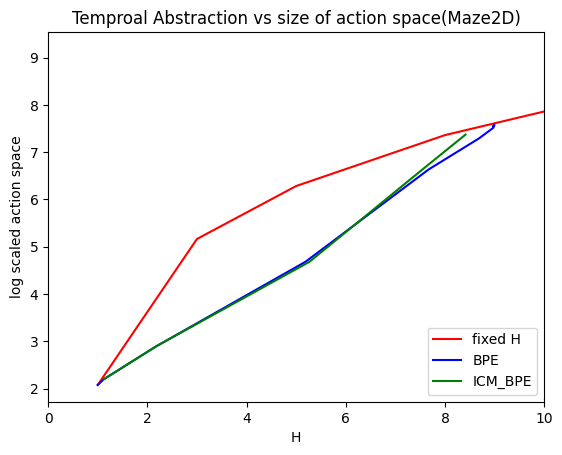

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.plot(temporal_abstraction, np.log(action_space), color="red", label='max_possible')
plt.plot(fixed_H_val_list, np.log(skill_kinds_list_fixedH), color="red", label='fixed H')
plt.plot(H_list_BPE, np.log(skill_kinds_list_BPE), color="blue", label='BPE')
plt.plot(H_list_ICM_BPE, np.log(skill_kinds_list_ICM_BPE), color="green", label='ICM_BPE')

plt.title("Temproal Abstraction vs size of action space(Maze2D)")
plt.xlabel("H")
plt.ylabel("log scaled action space")
plt.xlim(0,10)
plt.legend(loc="lower right")